### Dog Breed Classifier

Summary:  

This notebook builds a multi-class image classifier to determine the breed of a dog based upon 120 breeds.  This notebook will employ transfer learning by deploying the InceptionV3 model from TensorFlow Hub.  Additionally, I will use data augmentation on the images and fine-tune the model's last 20 layers to improve its accuracy.  For brevity, I will only show the best model's result.








Outline of the notebook:

1. Problem Statement
2. Data Source
3. Evaluation Metrics
4. Data Analysis
5. Modeling Data and Results
6. Conclusions


## 1. Problem Statement

Identify the breed of a dog based upon an image.



## 2.  Data Source

Data is from a [Kaggle dog breed identification competition](https://www.kaggle.com/c/dog-breed-identification/data).  There are train and test data folders with over 10,000 images each.

## 3. Evaluation Metrics

Evaluation will be a file of prediction probabilities for each image.  Kaggle will rank the results based upon a a multi-class log loss between predicted probability and observed target.

***Because I only know the correct breeds for the training set, improved results for the test set will be explained in differences from the computed multi-class log loss values; meaning, a lower value produces a better probability of prediction.***


## 4.  Data Features

120 different breeds of dog (120 classes) to be solved by deep learning; with 10,000+ images for the training and test sets, each.

## 5. Data Analysis

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.python.util.traceback_utils import include_frame
import tensorflow_hub as hub
import tensorflow as tf
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as pl
from IPython.display import display, Image
import datetime
from keras import models
from keras import layers
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model

np.random.seed(1)
tf.random.set_seed(1)

In [5]:
# Checkout the labels of our data

labels_csv = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())



                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


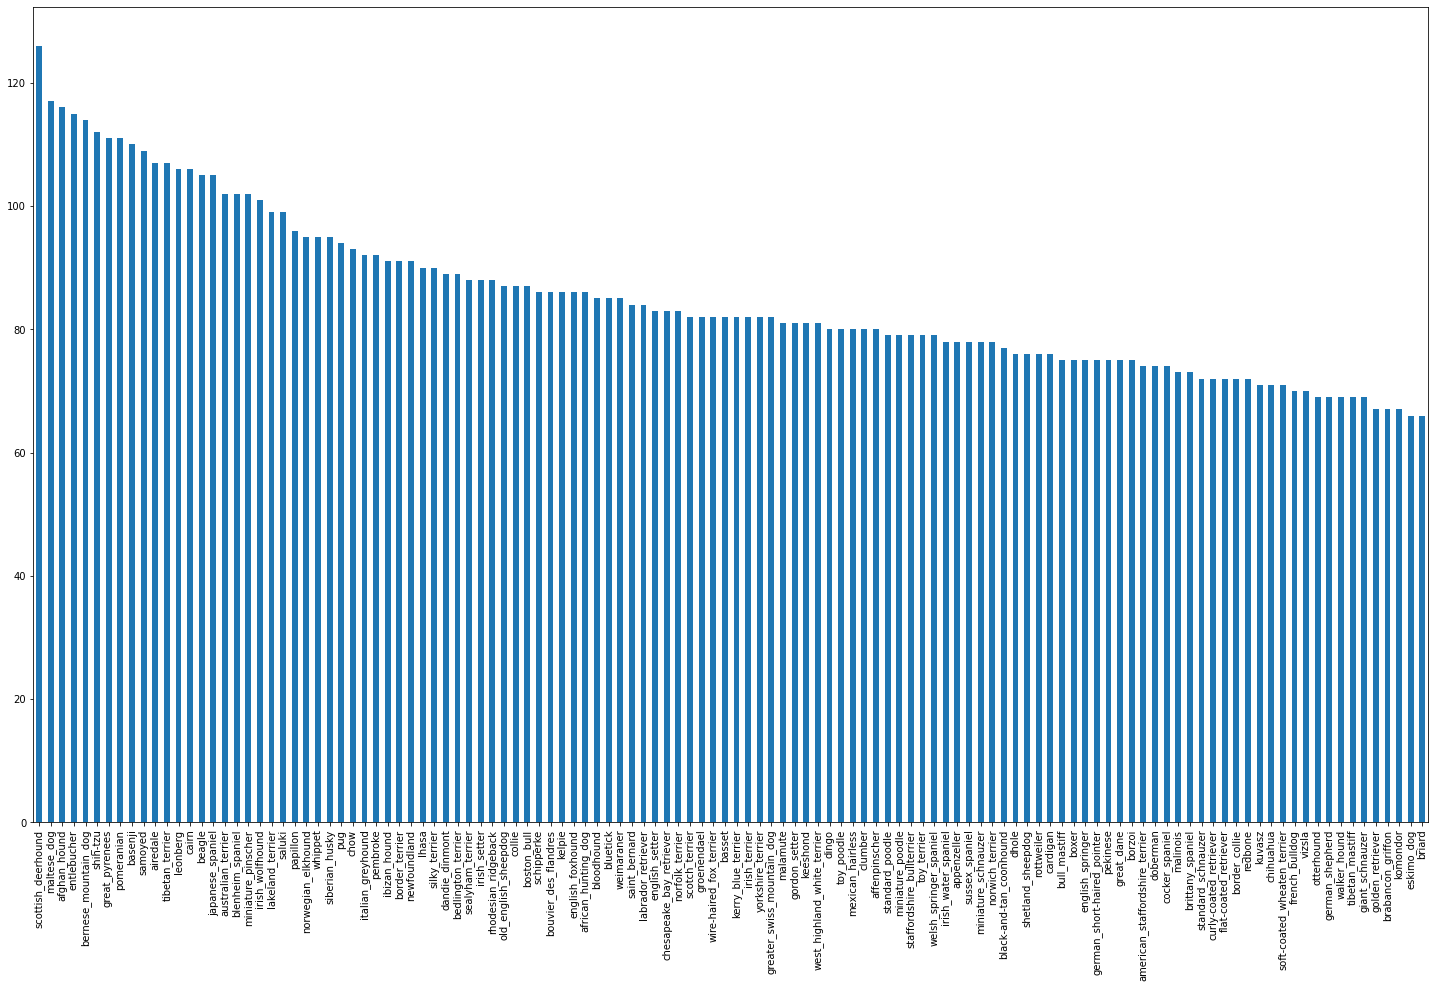

In [6]:
# Number of images for each breed
labels_csv["breed"].value_counts().plot.bar(figsize=(25, 15));

There are 120 breeds of dogs in this data set with each breed having between 80-120+ images.

### Creating X and y variables from filenames (X variable) and labels (y variable)

I will be using 1000 images to create my model and use an 80/20 split for training and validation.

In [7]:
# Generate pathnames from image IDs; this information will be our X variable

filenames = ["/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/train/" + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/train/001cdf01b096e06d78e9e5112d419397.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/train/002a283a315af96eaea0e28e7163b21b.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 '/content/drive/MyDrive/Colab Notebo

In [8]:
# Creating the y variable; need to put each breed into an array

labels = labels_csv["breed"].to_numpy() # convert labels column to NumPy array
labels[:10]

array(['boston_bull', 'dingo', 'pekinese', 'bluetick', 'golden_retriever',
       'bedlington_terrier', 'bedlington_terrier', 'borzoi', 'basenji',
       'scottish_deerhound'], dtype=object)

In [9]:
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [10]:
# Transform each label into a boolean array

boolean_labels = [label == np.array(unique_breeds) for label in labels]
boolean_labels[:1] # View a boolean array

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False])]

In [11]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000

In [12]:
# Set up X and y splits
X = filenames
y = boolean_labels

# Creating train/test splits (80/20) as well as validation sets
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES], 
                                                  test_size=0.2,
                                                  random_state=1)

len(X_train), len(y_train), len(X_val), len(y_val) # confirm sizes

(800, 800, 200, 200)

### Turning image files into Tensors

In [13]:
# Specify image size and augment

IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file, augments it, and turns it into a Tensor.
  """
  # Read in image file
  image = tf.io.read_file(image_path)
  
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)

  # Convert the colour channel values from 0-225 values to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)

  # Resize the image to our desired size (224 x 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image

### Generating Data Batches

In [14]:
# Function that returns a tuple of the image and its label
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a tuple of (image, label).
  """
  image = process_image(image_path)
  return image, label

In [15]:
# Define the batch size
BATCH_SIZE = 32

""" 
Note: Batch size implemantation was inspired by Danielle Bourke's analysis
https://github.com/mrdbourke/zero-to-mastery-ml/tree/master/section-4-unstructured-data-projects
"""

# Function to turn data into batches
def create_data_batches(x, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (x) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle it if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x))) # only filepaths
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data if a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    # If the data is a training dataset, we shuffle it
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), # filepaths
                                              tf.constant(y))) # labels

    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(x))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

### Training and Test Split Generation

In [16]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [17]:
# Check out the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Callback Functions

In [18]:
# Load the TensorBoard notebook extension
%reload_ext tensorboard

In [19]:
# Create a function to build a TensorBoard callback
def create_tensorboard_callback():
  # Create a log directory for storing TensorBoard logs
  logdir = os.path.join("/content/drive/MyDrive/Colab Notebooks/Logs",
                        # Make it so the logs get tracked whenever we run an experiment
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

In [20]:
# Create early stopping and saving
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="accuracy",
                                                  patience=3) # stops after 3 rounds of no improvements

checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0)

## 6. Modeling and Results

### Transfer Learning Model

Data augmentation was used as the accuracy on the training set would be 90%+ while on the validation set's accuracy would be 70%+.  

With fine-tuning and augmentation, I was able to achieve a validation accuracy -- that is predicted accuracy on a subset of training images not used in training -- of just over 80%.  This will be better when using the full data set.

In [21]:
# Data augmentation: horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomHeight(0.2),
  preprocessing.RandomWidth(0.2),
], name ="data_augmentation")

In [22]:
# Build Model Using Pre-trained Model
"""
Initially fine-tuned these paramaters on 10% of the data 
and used this model for the full data set
"""

# load InceptionV3 pre-trained model
base_model = InceptionV3(include_top = False, input_shape = (224,224,3))
base_model.trainable = True # enable model to be trained

# Freeze all layers except for the last 20
for layer in base_model.layers[:-20]:
  layer.trainable = False

model = models.Sequential()
model.add(base_model)
model.add(data_augmentation)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(512, 
                activation = 'relu'))
model.add(Dense(512, 
                activation = 'relu'))
model.add(Dense(120, 
                activation = 'softmax'))

# Verify last few layers of base can be trained
for layer_number, layer in enumerate(base_model.layers):
#  print(layer_number, layer.name, layer.trainable) # Verify layers

# Compile model
  model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [ ]:
# Summarize model
model.summary()

In [ ]:
# Create new TensorBoard session everytime we train a model
tensorboard = create_tensorboard_callback()

# Fit the model to the data passing it the callbacks we created
model.fit(x=train_data,
          epochs=100,
          validation_data=val_data,
          validation_freq=1, # check validation metrics every epoch
          callbacks=[tensorboard, 
                     early_stopping,
                     model_checkpoint])

In [ ]:
# Create Test Data

test_data = "/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/test/"
test_filenames = [test_data + fname for fname in os.listdir(test_data)]
test_filenames[:10]

### Running on Full Data

I will now use the test dataset of over 10,000 images and submit the results to Kaggle for evaluation.

In [24]:
len(X), len(y)

(10222, 10222)

In [25]:
full_data = create_data_batches(X, y)

Creating training data batches...


In [ ]:
# Create new TensorBoard session everytime we train a model
tensorboard = create_tensorboard_callback()

# Fit the model to the data passing it the callbacks we created
model.fit(x= full_data,
          epochs=100,
          callbacks=[tensorboard, 
                     early_stopping,
                     model_checkpoint])

In [27]:
  #Save Model
  
  suffix = "all-test-data-Adam"

  modeldir = os.path.join("/content/drive/MyDrive/Data/models/",
                          datetime.datetime.now().strftime("%Y%m%d-%H%M%s"))
  model_path = modeldir + "-" + suffix + ".h5"
  print(f"Saving model to: {model_path}...")
  model.save(model_path)

Saving model to: /content/drive/MyDrive/Data/models/20220725-18261658773595-all-test-data-Adam.h5...


### Making Predictions on Test Data

In [36]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [37]:
# Load test image filenames (since we're using os.listdir(), these already have .jpg)
test_path = "/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/test/"
test_filenames = [test_path + fname for fname in os.listdir(test_path)]

test_filenames[:10]

['/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/test/dfc9bcbafc1e249cd07a25c8f50384e0.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/test/e07e608afaa89ee4ee939ad0a3bd3224.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/test/e519e383a6efec0abd285beda04aeac9.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/test/e715a411098c046cac90c3facfa58c77.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/test/e3ff13afe2400a95e3ab76759d94fbc4.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/test/e644a1f6f9c69ee8f7e8d834730bbfd7.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/test/e64296ffbae301f86c8728834c507cb6.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/test/e440ec011c3c7ea94838ab5fc466159c.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/test/de90fcd52b9c527ea097d88804985516.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Dog B

In [38]:
# Number of images for the test set

len(test_filenames)

10357

In [39]:
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model# Create test data batch
test_data = create_data_batches(test_filenames, test_data=True)

Creating test data batches...


In [50]:
# Make predictions on test data batch using the loaded full model
test_preds = model.predict(test_data)

### Creating document for Kaggle Submission

In [ ]:
# Check out the test predictions
test_preds[:10]

In [43]:
# Create pandas DataFrame with empty columns
preds_df = pd.DataFrame(columns=["id"] + list(unique_breeds))
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier


In [44]:
# Append test image ID's to predictions DataFrame
test_path = "/content/drive/MyDrive/Colab Notebooks/Dog Breed Classifier/test/"
preds_df["id"] = [os.path.splitext(path)[0] for path in os.listdir(test_path)]
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,dfc9bcbafc1e249cd07a25c8f50384e0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,e07e608afaa89ee4ee939ad0a3bd3224,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,e519e383a6efec0abd285beda04aeac9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,e715a411098c046cac90c3facfa58c77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,e3ff13afe2400a95e3ab76759d94fbc4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Add the prediction probabilities to each dog breed column
preds_df[list(unique_breeds)] = test_preds
preds_df.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,dfc9bcbafc1e249cd07a25c8f50384e0,1.024524e-05,2.577324e-06,3.759036e-06,7.050188e-06,6.368777e-07,3.230409e-07,3.091371e-05,1.450629e-05,5.401826e-06,...,1.448738e-04,1.366611e-04,1.989254e-05,4.540069e-06,2.528771e-06,1.637752e-05,1.588138e-06,1.068557e-06,2.363731e-05,3.996144e-01
1,e07e608afaa89ee4ee939ad0a3bd3224,4.365685e-07,9.870886e-08,6.241159e-08,1.693940e-06,7.152761e-06,3.272176e-06,7.878883e-09,6.492109e-07,3.581104e-07,...,1.057258e-05,2.132814e-06,1.035706e-07,1.235887e-07,9.153670e-06,2.741502e-07,9.227694e-07,4.646631e-07,9.612625e-08,9.679139e-07
2,e519e383a6efec0abd285beda04aeac9,6.707887e-08,1.598644e-05,4.878325e-09,1.137101e-09,7.729508e-09,4.454069e-08,7.545027e-09,2.866689e-06,9.561958e-06,...,1.831154e-07,2.288179e-09,2.751803e-08,1.371319e-07,3.672935e-08,1.196590e-08,1.109973e-08,5.768732e-07,1.866243e-09,8.961344e-07
3,e715a411098c046cac90c3facfa58c77,9.434037e-09,1.895346e-08,2.009174e-09,1.758822e-09,1.029557e-07,9.174283e-09,1.442002e-08,5.279302e-09,1.755913e-08,...,3.231442e-08,3.434571e-07,1.855115e-09,7.895851e-10,1.956257e-08,2.997016e-08,3.717246e-07,6.393840e-10,2.045370e-05,5.733080e-08
4,e3ff13afe2400a95e3ab76759d94fbc4,2.952668e-08,1.142321e-09,3.143019e-09,3.467409e-07,5.554686e-07,8.869478e-08,4.657259e-10,1.109439e-07,3.038260e-08,...,8.224288e-06,6.634006e-08,2.747028e-08,2.767321e-09,4.824589e-08,2.017516e-08,7.061819e-09,1.506964e-09,2.413278e-08,8.239380e-09


In [48]:
preds_df.to_csv("drive/My Drive/Data/full_submission_1_InceptionV3_adam.csv",
                 index=False)

The submitted result had a score of 0.934.  Originally, before any image augmentation or fine tuning, the score was just over 20.  The purpose of this notebook was to show how transfer learning can be improved by fine-tuning and image augmentation.  I will disucss my results more in the conclusions.

## 7. Conclusions

With fine tuning and augmentation I was able to improve the score from ~20 to 0.934.  This places the results in the top 9% of submissions.  Please note I only trained my model for several epochs and stopped when there was no more progress via an early callback.

A ton of [submissions have scores below 0.05](https://www.kaggle.com/competitions/dog-breed-identification/leaderboard), which is remarkable given the size of the data set.  Both the train and test sets came from the [Stanford Dogs data set](https://www.kaggle.com/competitions/dog-breed-identification/discussion/40779). it is easy to then train an overfitted model on the data, which I presume a ton of these leaders did. This model could be further improved with a different pre-trained model (ResNet50, etc.) and using more fine tuning.